# Imports
Imports and configurations are handled here as needed.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from scipy.stats import ttest_rel

import warnings
warnings.filterwarnings("ignore")

# Data Preparation
Load the data from text files and preprocess it.

In [2]:
# base_path = "/blue/hcds_hackathon/hackathon_projects/lung_cancer_metabolomics/metabolite_data/"
base_path = "data/"
data1_path = base_path + "ST000368_1.txt"
data2_path = base_path + "ST000369.txt"

In [3]:
# function to convert file to pandas dataframe
def process_data(data_path, metabolite_offset):
    with open(data_path) as f:
        lines = f.read().split("\n")

    ## the first line is patient IDs
    keys = lines[0].split("\t")
    # print(len(keys))

    ## the second line is clinical data for each patient ID (organ/cancer/smoker/gender)
    clinical_data = [x.split(" | ") for x in lines[1].split("\t")]
    clinical_data = [([y.split(":")[len(y.split(":")) - 1] for y in x]) for x in clinical_data]
    # print(len(clinical_data))

    result = dict(zip(keys, clinical_data))
    
    ## the remaining lines are metabolomics
    ## error, some lines are NA. figure out where NA should be removed when attaching metabolomics
    for n in range(2, len(lines)):
        split_metabolics = lines[n].split("\t")
        zipped = list(zip(keys, split_metabolics))
        for x in zipped:
            result[x[0]].append(x[1])

    ## remove these rows as they are column names/identifiers for metabolites and not informative 
    metabolites = result.pop("Metabolite_name")
    refmet_name = result.pop("RefMet_name")
    keys.remove("Metabolite_name")
    keys.remove("RefMet_name")

    ## create column names and generate a dataframe to return
    colnames = ["Organ", "Cancer", "Smoker", "Gender"]
    for x in metabolites[1:-1]:
        colnames.append(x)
        
    df = pd.DataFrame(result).T
    df.columns = colnames

    return df

df1 = process_data(data1_path, 2)
df2 = process_data(data2_path, 2)
combined_df = pd.concat([df1, df2])[(list(set(df1.columns) & set(df2.columns)))]

# combined_df.to_csv("metabolites.csv")
combined_df


,cholesterol,quinic acid,maltotriose,arabinose,2-hydroxybutanoic acid,lauric acid,serine,myristic acid,nicotinic acid,glycine,...,trans-4-hydroxyproline,tyrosine,N-acetylglutamate,proline,ethanolamine,5-methoxytryptamine,oxoproline,gluconic acid,caprylic acid,2_3-dihydroxybutanoic acid NIST
140225dlvsa44_1,59943,359,94,159,7786,1504,7262,619,133,53146,...,545,19773,241,51773,1789,314,24969,152,371,74
140226dlvsa30_1,87805,207,96,308,15277,1208,14959,613,83,76963,...,1154,34192,313,124165,837,304,80978,232,1487,146
140226dlvsa36_1,92716,544,91,500,7794,1775,14038,544,108,129903,...,721,25122,272,76766,880,246,94906,245,2148,183
140227dlvsa36_1,67235,1007,152,294,9810,1616,5303,1062,83,88858,...,1466,22736,569,66456,662,83,94041,366,1740,152
140227dlvsa47_1,105437,1635,261,132,12725,2214,6784,1259,79,108946,...,1068,35948,405,29871,645,744,92369,200,1581,202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130730dlvsa12_1,34689,437,108,148,16595,1916,13547,931,84,79283,...,818,33787,357,59056,721,473,36145,212,480,95
130730dlvsa25_1,12431,997,78,111,15472,1897,20241,775,114,107436,...,1927,31817,265,99980,696,79,44406,186,640,163
130730dlvsa43_1,23211,147,63,219,15952,1273,14916,471,42,69166,...,967,21777,279,82526,2673,36,37851,176,639,112
130730dlvsa49_1,32886,135,95,280,12561,1658,16469,1067,213,97680,...,449,20170,385,64509,2776,586,52389,221,980,129


In [4]:
data = combined_df.copy()
data = data[data["Gender"] != "NA"]

y = (data["Cancer"] == "Healthy").map({False: 1, True: 0})
X_metabolics = data.drop("Cancer", axis=1).drop(["Organ", "Smoker", "Gender"], axis=1)

X_clinical = data.drop("Cancer", axis=1).drop(["Organ"], axis=1)
X_clinical["Smoker"] = X_clinical["Smoker"].map({"Former": 0, "Current": 1})
X_clinical["Gender"] = X_clinical["Gender"].map({"F": 0, "M": 1})

def na_vals(X):
    X = X.replace("", np.nan)
    X = X.apply(pd.to_numeric)
    X = X.fillna(X.mean(numeric_only=True))
    return X

X_clinical = na_vals(X_clinical)
X_metabolics = na_vals(X_metabolics)

# Comparison of Model Performance - Clinical Data
Compare how the model performs when including clinical data and excluding clinical data.

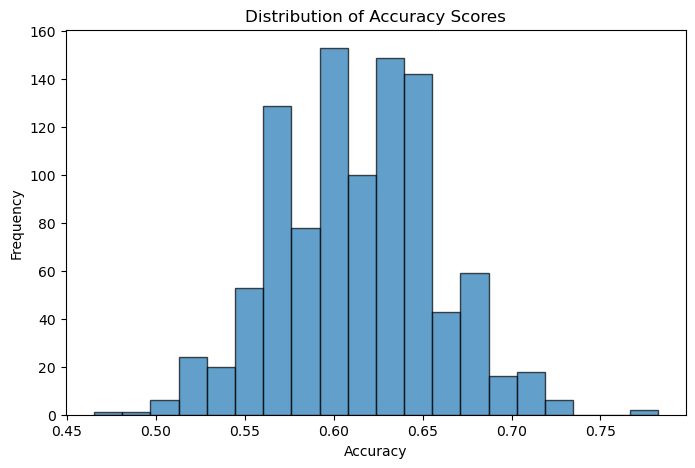

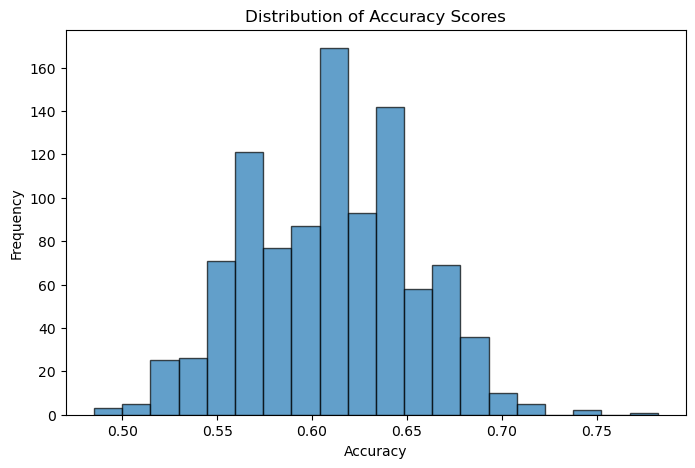

No significant difference between data with and without clinical features (t=-6.522, p=0.0000)


In [5]:
scaler = StandardScaler()

count = 0
saved_model = None
prev_acc = 0

accuracy_list = []
coef_list = []
acc2_list = []
coef2_list = []

while (count < 1000):
    # if (count % 1000 == 0):
    #     print(count)
    count += 1
    ## metabolics
    X_train, X_test, y_train, y_test = train_test_split(X_metabolics, y, test_size=0.3, random_state=count)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracy_list.append(acc)
    coef_list.append(model.coef_[0])

    ## clinical data
    X_train, X_test, y_train, y_test = train_test_split(X_clinical, y, test_size=0.3, random_state=count)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc2_list.append(acc)
    coef2_list.append(model.coef_[0])

def plot_accuracies(acc_list):
    plt.figure(figsize=(8,5))
    plt.hist(acc_list, bins=20, edgecolor='k', alpha=0.7)
    plt.xlabel("Accuracy")
    plt.ylabel("Frequency")
    plt.title("Distribution of Accuracy Scores")
    plt.show()

plot_accuracies(accuracy_list)
plot_accuracies(acc2_list)

# paired differences
t_stat, p_two_sided = ttest_rel(acc2_list, accuracy_list)
p_one_sided = p_two_sided / 2

if t_stat > 0 and p_one_sided < 0.05:
    print(f"Accuracies without clinical data are significantly higher (t={t_stat:.3f}, p={p_one_sided:.4f})")
else:
    print(f"No significant difference between data with and without clinical features (t={t_stat:.3f}, p={p_one_sided:.4f})")

# Comparison of Model Performance - Metabolics
Compare how the model performs when using a variable number of metabolics to predict.

In [6]:
X = X_metabolics
coef_df = pd.DataFrame(coef_list, columns=X.columns)
coef_df['accuracy'] = accuracy_list
coef_df.sort_values(by='accuracy', ascending=False)

coef_70 = coef_df[coef_df['accuracy'] >= 0.7]

coef_summary = coef_70.drop(columns='accuracy').agg(['mean', 'std']).T
coef_summary['abs_mean'] = coef_summary['mean'].abs()
coef_summary = coef_summary.sort_values(by='abs_mean', ascending=False)

In [ ]:
median_accuracy =  []
idx = [x+1 for x in range(len(X.columns))]

for n in range(len(X.columns)):
    n = n + 1
    # print("TOP",n,"METABOLICS")
    topn = coef_summary.head(n).index.values
    X_n = X_metabolics[topn]
    
    seed = 42
    scaler = StandardScaler()
    count = 0
    saved_model = None
    prev_acc = 0
    accuracy_list = []
    coef_list = []
    
    while (count < 500):
        # if (count % 1000 == 0):
        #     print(count)
        count += 1
        X_train, X_test, y_train, y_test = train_test_split(X_n, y, test_size=0.3, random_state=count)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        model = LogisticRegression()
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracy_list.append(acc)
        coef_list.append(model.coef_[0])

        if (acc > prev_acc):
            saved_model = model
            prev_acc = acc
            # print("Models evaluated:", count)
            # print("Accuracy:", accuracy_score(y_test, y_pred))
            # print("\nClassification Report:\n", classification_report(y_test, y_pred))
            
    
    median_accuracy.append(np.median(accuracy_list))
    # plt.figure(figsize=(8,5))
    # plt.hist(accuracy_list, bins=20, edgecolor='k', alpha=0.7)
    # plt.xlabel("Accuracy")
    # plt.ylabel("Frequency")
    # plt.title("Distribution of Accuracy Scores with top " + str(n) + " metabolics")
    # plt.show()

plt.plot(idx, median_accuracy)
plt.title("Median accuracy vs # of metabolics")
plt.show()